In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from text_clean import *


import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import pandas as pd

analyser = SentimentIntensityAnalyzer()

def label_stocks(row):
    if row['Close'] >= row['yesterday_close']:
        return 1
    else:
      return 0

def label_sentiment(row):
    sent = analyser.polarity_scores(row['text'])
    return pd.Series([sent['neg'], sent['neu'], sent['pos'], sent['compound']])

    

# File paths
apple_stocks = "Data/Stock data/Stocks/aapl.us.txt"
amazon_stocks = "Data/Stock data/Stocks/amzn.us.txt"
facebook_stocks = "Data/Stock data/Stocks/fb.us.txt"

apple_headlines = "Data/News data/apple_deduped.csv"
amazon_headlines = "Data/News data/amazon_deduped.csv"
facebook_headlines = "Data/News data/facebook_deduped.csv"

apple_reddit = "Data/News data/apple_reddit.csv"
amazon_reddit = "Data/News data/amazon_reddit.csv"
facebook_reddit = "Data/News data/facebook_reddit.csv"

apple_tweets = "Data/Tweets/apple_tweets.csv"
amazon_tweets = "Data/Tweets/amazon_tweets.csv"
facebook_tweets = "Data/Tweets/facebook_tweets.csv"

# Twitter date parser
mydateparser = lambda x: pd.datetime.strptime(x[:10] + " " + x[-4:], "%a %b %d %Y")

# Read in text data and stock data
df = pd.read_csv('Data/Tweets/apple_tweets.csv', parse_dates=[1], date_parser=mydateparser)
# df = pd.read_csv(apple_headlines, parse_dates=[1])
df = df.set_index(['Date'])

df_new = pd.DataFrame()

for _, group in df.groupby(df.index):
    n = 50 if len(group) >= 50 else len(group)
    df_new = pd.concat([df_new, group.sample(n)])
    
#df = df_new
df[['neg', 'neu', 'pos', 'compound']] =  df.apply(label_sentiment, axis=1)

stock = pd.read_csv('aapl_indicators.us.txt', parse_dates=[0])
stock['yesterday_close'] = stock['Close'].shift()
stock['value'] = stock.apply(lambda row: label_stocks(row), axis=1)

stock.loc[:, 'High':'yesterday_close'] = stock.loc[:, 'High':'yesterday_close'].shift()

In [72]:
# Rename twitter columns if necessary
# df.rename({'created_at': 'Date'}, inplace=True, axis=1)

df = pd.merge(df, stock, on="Date", how="inner")
df.drop('Close', axis=1, inplace=True)

"""
BALANCE CLASSES
"""
# Class count
count_class_1, count_class_0 = df.value.value_counts()

# Divide by class
df_class_0 = df[df['value'] == 0]
df_class_1 = df[df['value'] == 1]

if count_class_1 > count_class_0:
    df_class_1_under = df_class_1.sample(count_class_0)
    df = pd.concat([df_class_1_under, df_class_0], axis=0)
else:
    df_class_0_under = df_class_0.sample(count_class_1)
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    

df = df.set_index(['Date'])
df.sort_index(inplace=True)

In [4]:
df

,text,user_id_str,neg,neu,pos,compound,Open,High,Low,Volume,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,yesterday_close,value
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,$ aapl us stocks-wall st kicks off new year on...,1604673104,0.167,0.833,0.000,-0.2960,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,rt AT_USER our top 3 trade ideas for 2014 and ...,1951070833,0.000,0.776,0.224,0.6705,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,AT_USER $ aapl having breathing difficulties,915436742,0.355,0.645,0.000,-0.2960,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,emylers : cheeky's board ! : $ aapl up to date...,2197099980,0.000,1.000,0.000,0.0000,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,$ aapl blackberry and singer alicia keys to pa...,1604673104,0.000,1.000,0.000,0.0000,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,$ aapl - chinas xiaomi says to more than doubl...,153395860,0.000,1.000,0.000,0.0000,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,what are your top picks for q1 2014 ? here are...,24312698,0.000,0.893,0.107,0.2023,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,$ aapl how is tim cook doing taking over from ...,1934537768,0.000,1.000,0.000,0.0000,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0
2014-01-02,rt AT_USER apple gained 8 % in 2013 vs s & p's...,85837311,0.000,0.804,0.196,0.6287,73.596,74.338,73.374,60185593.0,...,56.367382,67.161452,59.709218,-32.838548,1.990300,1.168221,1.161450,17429.253562,73.445,0


In [73]:
scaler = StandardScaler()
df.loc[:, 'neg': 'yesterday_close'] = scaler.fit_transform(df.loc[:, 'neg': 'yesterday_close'])

Preprocess and split data into train and test sets

In [74]:
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x.loc[:, 'neg': 'yesterday_close'], validate=False)

# df['text'] = df['text'].str.replace('[^\w\s]',' ')

#X = features, y = class labels
X = df.loc[:, 'text': 'yesterday_close']
y = df.loc[:, 'value']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Avoid having same days in train and test set
X_train, y_train = shuffle(X.loc[:'2015-07-26'], y.loc[:'2015-07-26'])
X_test, y_test = shuffle(X.loc['2015-07-27':], y.loc['2015-07-27':])

In [41]:
X_train

,text,user_id_str,neg,neu,pos,compound,Open,High,Low,Volume,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,yesterday_close
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-13,apple's supplier contracts include $ 50m penal...,950517078,1.855184,-0.571612,-0.674739,-1.745285,-0.315958,-0.324407,-0.311161,0.130037,...,0.145280,-0.340113,0.014302,0.072819,0.014302,-0.336222,-0.175558,-0.166750,-0.339672,-0.324032
2014-06-19,avoid mistakes like $ tds $ aapl $ gntx $ cag ...,2496251071,3.914029,-3.263678,1.012543,-1.228159,-0.817518,-0.858759,-0.815078,-0.943889,...,1.937314,-0.595495,-0.138933,-0.182185,-0.138933,0.674846,0.043900,0.052295,-0.818073,-0.820556
2015-02-13,"commented on : "" gilead : no reason to panic h...",89491245,4.195895,-2.011905,-0.674739,-2.417740,1.111350,1.064197,1.098612,0.378070,...,0.387640,1.448917,1.236411,1.438333,1.236411,1.884043,0.728775,0.730645,1.081118,0.993314
2014-07-22,"$ aapl misses on revenue , beats on earnings URL",19357082,2.161560,-0.760132,-0.674739,-1.006761,-0.691820,-0.717459,-0.688829,-0.761728,...,1.461892,-1.247808,-0.895925,-0.712248,-0.895925,0.148827,-0.325966,-0.317350,-0.725241,-0.696720
2014-07-22,rt AT_USER AT_USER AT_USER AT_USER - how are y...,1927298154,-0.448762,0.039193,0.280494,0.354666,-0.691820,-0.717459,-0.688829,-0.761728,...,1.461892,-1.247808,-0.895925,-0.712248,-0.895925,0.148827,-0.325966,-0.317350,-0.725241,-0.696720
2014-08-21,rt AT_USER apple trades above its split-adjust...,582689833,-0.448762,0.846059,-0.674739,-0.287930,-0.355428,-0.374324,-0.329920,-0.319469,...,1.103754,1.748833,1.200477,1.373326,1.200477,0.464593,0.001055,0.009595,-0.348342,-0.348788
2014-04-24,rt AT_USER $ aapl and $ fb calls--reading them...,106498703,-0.448762,0.846059,-0.674739,-0.287930,-1.425770,-1.736413,-1.713090,1.206349,...,-0.792346,0.758896,-0.471700,-0.060301,-0.471700,-0.458529,-0.785709,-0.780105,-1.749034,-1.691564
2015-06-12,nflx noranda aluminum holding corp . prev clos...,1850041968,-0.448762,-0.179490,0.539390,0.652300,1.187599,1.234847,1.283922,-0.901446,...,-0.144457,-0.761713,-0.562516,-0.762964,-0.562516,-0.394026,-0.159237,-0.150431,1.222983,1.236383
2014-02-18,short seller jim chanos ' long stock picks URL...,194137231,-0.448762,0.846059,-0.674739,-0.287930,-1.592508,-1.626463,-1.586102,0.224296,...,-0.711221,1.115250,1.294992,1.016631,1.294992,-0.163208,-0.068005,-0.059296,-1.604692,-1.596301


In [46]:
X_train

,text,user_id_str,neg,neu,pos,compound,Open,High,Low,Volume,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,yesterday_close
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-13,apple's supplier contracts include $ 50m penal...,950517078,9.275920,-2.858060,-3.373697,-1.745285,-0.315958,-0.324407,-0.311161,0.130037,...,0.145280,-0.340113,0.014302,0.072819,0.014302,-0.336222,-0.175558,-0.166750,-0.339672,-0.324032
2014-06-19,avoid mistakes like $ tds $ aapl $ gntx $ cag ...,2496251071,19.570146,-16.318388,5.062715,-1.228159,-0.817518,-0.858759,-0.815078,-0.943889,...,1.937314,-0.595495,-0.138933,-0.182185,-0.138933,0.674846,0.043900,0.052295,-0.818073,-0.820556
2015-02-13,"commented on : "" gilead : no reason to panic h...",89491245,20.979475,-10.059524,-3.373697,-2.417740,1.111350,1.064197,1.098612,0.378070,...,0.387640,1.448917,1.236411,1.438333,1.236411,1.884043,0.728775,0.730645,1.081118,0.993314
2014-07-22,"$ aapl misses on revenue , beats on earnings URL",19357082,10.807799,-3.800660,-3.373697,-1.006761,-0.691820,-0.717459,-0.688829,-0.761728,...,1.461892,-1.247808,-0.895925,-0.712248,-0.895925,0.148827,-0.325966,-0.317350,-0.725241,-0.696720
2014-07-22,rt AT_USER AT_USER AT_USER AT_USER - how are y...,1927298154,-2.243808,0.195964,1.402472,0.354666,-0.691820,-0.717459,-0.688829,-0.761728,...,1.461892,-1.247808,-0.895925,-0.712248,-0.895925,0.148827,-0.325966,-0.317350,-0.725241,-0.696720
2014-08-21,rt AT_USER apple trades above its split-adjust...,582689833,-2.243808,4.230293,-3.373697,-0.287930,-0.355428,-0.374324,-0.329920,-0.319469,...,1.103754,1.748833,1.200477,1.373326,1.200477,0.464593,0.001055,0.009595,-0.348342,-0.348788
2014-04-24,rt AT_USER $ aapl and $ fb calls--reading them...,106498703,-2.243808,4.230293,-3.373697,-0.287930,-1.425770,-1.736413,-1.713090,1.206349,...,-0.792346,0.758896,-0.471700,-0.060301,-0.471700,-0.458529,-0.785709,-0.780105,-1.749034,-1.691564
2015-06-12,nflx noranda aluminum holding corp . prev clos...,1850041968,-2.243808,-0.897452,2.696948,0.652300,1.187599,1.234847,1.283922,-0.901446,...,-0.144457,-0.761713,-0.562516,-0.762964,-0.562516,-0.394026,-0.159237,-0.150431,1.222983,1.236383
2014-02-18,short seller jim chanos ' long stock picks URL...,194137231,-2.243808,4.230293,-3.373697,-0.287930,-1.592508,-1.626463,-1.586102,0.224296,...,-0.711221,1.115250,1.294992,1.016631,1.294992,-0.163208,-0.068005,-0.059296,-1.604692,-1.596301


In [156]:
X_test.drop(X_test.columns[indx], axis=1, inplace=True)

In [33]:
names = list(X_train)
w = [(k, 1) for k in list(X_train)]
weights = {key: value for (key, value) in w}
weights['neg'] = 5
weights['neu'] = 5
weights['pos'] = 5

In [157]:
from sklearn.linear_model import SGDClassifier
get_numeric_data = FunctionTransformer(lambda x: x.loc[:, 'pos': 'yesterday_close'], validate=False)

vect = TfidfVectorizer(analyzer=preprocess_text, strip_accents='unicode', ngram_range=(1, 3))

model = Pipeline([
    ('features', FeatureUnion([
               ('numeric_features', Pipeline([
                   ('selector', get_numeric_data)
               ])),
#                  ('text_features', Pipeline([
#                     ('selector', get_text_data),
#                     ('vec',  vect)
#                 ]))
         ])),
    # ('clf', SGDClassifier(class_weight='balanced', fit_intercept=False, penalty='l1'))
    #('clf', KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm='brute')),
    ('clf', LinearSVC(class_weight='balanced', fit_intercept=False, penalty='l1', dual=False, C=0.2)),
])

model.fit(X_train, y_train)
print(model.score(X_train, y_train))
y_pred = model.predict(X_test)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred) * 100))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred), "\n")

0.7294723871401366
Accuracy: 65.73%

F1 Score: 63.95

Confusion Matrix:
 [[1021  548]
 [ 442  878]] 



f:\documents\cpsc 571 project\venv\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Graph most influential words:

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

# model.named_steps['features'].transformer_list[1][1].named_steps['vec']
Xtr = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].fit_transform(X['text'])
features = model.named_steps['features'].transformer_list[1][1].named_steps['vec'].get_feature_names()
feats = top_feats_by_class(Xtr, y, features)

plot_tfidf_classfeats_h(feats)

In [ ]:
# Time Series split?
X = df.loc[:, 'text': 'yesterday_close']
y = df['value']
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    print("Y_TRAIN")
    print(y_train)
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("Y_TEST")
    print(y_test)

# Plot ROC Curve along with other stats

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
from matplotlib import pyplot

def evaluate(classifier):
    predicted = classifier.predict(X_test)
    if isinstance(classifier.steps[1][1], LinearSVC):
        probabilities = np.array(classifier.decision_function(X_test))
        scores = probabilities
    else:
        probabilities = np.array(classifier.predict_proba(X_test))
        scores = probabilities[:, 1]  # NEW

    testing_category_array = np.array(y_test)  # NEW
    pos_idx = np.where(testing_category_array == 1)
    predicted_true_binary = np.zeros(testing_category_array.shape)
    predicted_true_binary[pos_idx] = 1
    fpr, tpr, thresholds = roc_curve(predicted_true_binary, scores)
    auc = roc_auc_score(predicted_true_binary, scores)

    mean_acc = np.mean(predicted == y_test)
    report = classification_report(y_test, predicted)

    return fpr, tpr, auc, mean_acc, report

fpr, tpr, auc, mean_acc, report = evaluate(model)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

In [158]:
feats = FeatureUnion([
              ('numeric_features', Pipeline([
                  ('selector', get_numeric_data)
              ])),
#                 ('text_features', Pipeline([
#                    ('selector', get_text_data),
#                    ('vec',  vect)
#                ]))
         ])

data = feats.fit_transform(X_train)

In [152]:
# indx = np.where(abs(tsvd.components_[0]) <= 0.01)
indx = [0, 1, 2, 3, 12, 20, 21, 25, 26, 29, 30, 31, 32, 42, 46, 47, 55, 63]
X_train.drop(X_train.columns[indx], axis=1)

,pos,compound,Open,High,Low,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,yesterday_close
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-29,1.182353,0.461245,-1.921623,-1.872564,-1.899691,6.887754,-1.331534,-3.915000,-0.788868,-7.166049,...,0.170152,-0.189503,-1.611477,-1.644095,-1.644095,-0.569144,-4.716777,-4.892562,-1.902650,-1.570329
2015-07-22,-0.672783,-0.285227,0.862047,1.385304,1.387900,0.443421,-0.664423,-1.099707,-0.635102,0.457294,...,-0.292120,-0.592464,1.106309,0.876959,0.876959,0.281689,-0.602912,-0.595578,1.343878,1.411283
2014-04-24,-0.021702,0.183939,-1.420011,-1.730611,-1.707513,1.209008,-0.714315,-1.434164,-0.457708,-0.215442,...,-0.989487,-0.792450,0.758340,-0.472921,-0.472921,-0.460560,-0.787384,-0.781661,-1.743239,-1.686463
2014-01-02,-0.672783,-0.691815,-1.538337,-1.532209,-1.508744,-0.186564,0.400285,0.811952,-0.655837,0.177856,...,-1.320923,0.819048,0.415082,0.324651,0.324651,0.257834,0.666518,0.669165,-1.496440,-1.540355
2015-01-13,0.005055,0.357375,0.248835,0.261346,0.173578,-0.428186,-0.477761,-0.718934,-1.224872,0.389758,...,-0.139762,-0.226163,-0.277999,-0.388688,-0.388688,-1.107280,-1.472063,-1.477536,0.141960,0.289228
2014-10-24,-0.672783,-1.996076,-0.106369,-0.161236,-0.128156,0.286238,0.264510,1.018502,-0.351305,-0.276595,...,0.428637,-0.056562,0.603519,1.337228,1.337228,-0.017224,1.021746,1.018248,-0.117668,-0.213423
2015-02-11,0.638299,0.433610,0.876060,0.786378,0.811140,-0.031614,1.428289,0.879644,-0.352785,0.641638,...,1.918683,0.193423,1.325286,1.382918,1.382918,1.498847,1.111229,1.105856,0.847580,0.723120
2015-03-18,-0.672783,-0.285227,1.101390,1.060284,1.107760,-0.388760,1.143860,0.723620,-0.524609,0.155881,...,1.000180,0.621088,-0.630948,0.043227,0.043227,-0.402276,0.964892,0.962517,1.115986,1.002090
2015-02-03,-0.672783,-0.285227,0.623825,0.605812,0.565662,0.000029,-0.461731,0.893468,-0.841851,0.229366,...,1.065184,-0.155496,0.097586,1.108467,1.108467,0.946901,0.716499,0.718408,0.641634,0.562586


In [114]:
tsvd.components_[0]

array([ 0.00453221, -0.00405926,  0.00149288, -0.00341836, -0.22180676,
       -0.22260805, -0.22212697,  0.07829773,  0.02643615,  0.01683218,
        0.0508989 ,  0.05517082,  0.00509395,  0.01282542,  0.015414  ,
       -0.11744842, -0.13990536, -0.21968616, -0.22529416, -0.22399531,
        0.00174485, -0.00905866, -0.22416342, -0.22381919, -0.22428479,
        0.        ,  0.        , -0.22086942, -0.22497593,  0.00480117,
       -0.00099088, -0.00092033, -0.00821571,  0.02042713, -0.22432091,
       -0.22331783,  0.03476114,  0.05808549, -0.04618866,  0.03747425,
       -0.01715901,  0.02664691,  0.00704149,  0.0282506 ,  0.02488505,
       -0.02201333,  0.00640481,  0.00153447,  0.01509346, -0.22466322,
       -0.22129338, -0.21092883, -0.2056268 ,  0.01021717,  0.02175355,
       -0.00620304,  0.04064465,  0.0395545 ,  0.02454802,  0.03943189,
        0.02980869,  0.02598489,  0.02980869,  0.00181681,  0.01436207,
        0.01431077, -0.22201655, -0.22265651])

In [122]:
np.where(abs(tsvd.components_[0]) <= 0.01)

(array([ 0,  1,  2,  3, 12, 20, 21, 25, 26, 29, 30, 31, 32, 42, 46, 47, 55,
        63], dtype=int64),)

In [159]:
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE

tsvd = TruncatedSVD(n_components=3)
# tsvd = TSNE(n_components=2, verbose=1)
pca = tsvd.fit(data)
pca_2d = tsvd.transform(data)

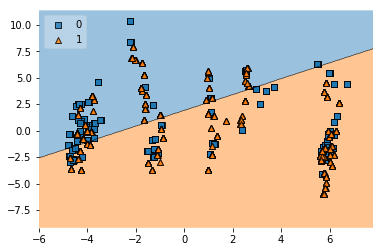

In [160]:
svmClassifier_2d =   model.named_steps['clf'].fit(pca_2d, y_train)

value = 3
# Plot training sample with feature 3 = 1.5 +/- 0.75
width = 3

plot_decision_regions(X=pca_2d, y=y_train.values, clf=svmClassifier_2d, filler_feature_values={2: value},
                      filler_feature_ranges={2: width}, legend=2)